In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from datetime import datetime 

In [2]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket='noshows3'
data_key = 'df_clean.csv'
data_location = 's3://{0}/{1}'.format(bucket, data_key)
df = pd.read_csv(data_location)

In [3]:
df=df.drop(['Unnamed: 0', 'ScheduledDay', 'AppointmentDay'], axis=1)
df=df.set_index(['PatientId', 'AppointmentID'])
df.head(1)

,,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,appointmentDay,scheduledDay,Interval,Period
PatientId,AppointmentID,,,,,,,,,,,,,,
2.987250e+13,5642903,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Friday,Friday,0,Afternoon


In [5]:
#culling the extreme outliers of our interval feauture 
df_mask=df['Interval']<=58
filtered_df=df[df_mask]
print(len(df))
print(len(filtered_df))
print(filtered_df['Interval'].quantile(1))

110526
108358
58.0


In [6]:
pip install sklearn-pandas

Note: you may need to restart the kernel to use updated packages.


In [8]:
print(filtered_df.select_dtypes(include=['object', 'category']).columns)
print(filtered_df.select_dtypes(include=['float64', 'int64']).columns)

Index(['Gender', 'Neighbourhood', 'No-show', 'appointmentDay', 'scheduledDay',
       'Period'],
      dtype='object')
Index(['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism',
       'Handcap', 'SMS_received', 'Interval'],
      dtype='object')


In [9]:
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
# code partially inspired from above 
# The best practice when encoding variables is to fit the encoding on the training dataset, 
# then apply it to the train and test datasets.

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

def encode_categorical_cols(dataframe):
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns
    numerical_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    mapping = []
    mapping += ((col, LabelEncoder()) for col in categorical_columns)
    mapping += ((col, None) for col in numerical_columns)
        
    mapper = DataFrameMapper(mapping, df_out=True)
    
    stages = []
    stages += [("pre_processing_mapper", mapper)]
    
    pipeline = Pipeline(stages)
    transformed_df = pipeline.fit_transform(dataframe)
    return transformed_df

encoded_data = encode_categorical_cols(filtered_df)
encoded_data.dtypes

Gender            int64
Neighbourhood     int64
No-show           int64
appointmentDay    int64
scheduledDay      int64
Period            int64
Age               int64
Scholarship       int64
Hipertension      int64
Diabetes          int64
Alcoholism        int64
Handcap           int64
SMS_received      int64
Interval          int64
dtype: object

In [10]:
#X Data
X = encoded_data.drop(['No-show'], axis = 1, inplace = False)

#y Data
y = encoded_data['No-show']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 191, shuffle=True)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Establish exhaustive gri search 
# https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

forest = RandomForestClassifier(random_state = 191)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = None, verbose = 2, 
                      n_jobs = -1) #None to use default 5-fold cross validation 
bestF = gridF.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [10]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


KeyboardInterrupt: 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


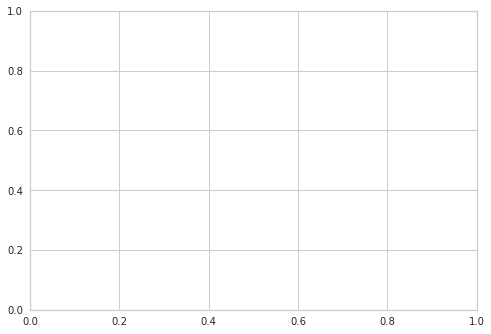

In [11]:
# https://towardsdatascience.com/validation-curve-explained-plot-the-influence-of-a-single-hyperparameter-1ac4864deaf8
# https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

from yellowbrick.model_selection import validation_curve 

rf = RandomForestClassifier(random_state=191, n_estimators = 800, min_samples_split=2, min_samples_leaf=1)

print(validation_curve(rf, #from below borrwing optimal params 
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = max_depth , cv = 5, scoring='accuracy'))

In [ ]:
rf = RandomForestClassifier(random_state=191, max_depth=15, min_samples_split=2, min_samples_leaf=1)

print(validation_curve(rf, #from below borrwing optimal params 
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = n_estimators , cv = 5, scoring='accuracy'))

In [ ]:
print(bestF.best_params_, bestF.best_score_)

In [ ]:
bestF.cv_results_

In [ ]:
bestF.best_index_

In [ ]:
bestF.scorer_

In [22]:
forestOpt = RandomForestClassifier(random_state = 191, max_depth = 15,     
n_estimators = 800, min_samples_split = 2, min_samples_leaf = 1)

modelOpt = forestOpt.fit(X_train, y_train)
y_pred = forestOpt.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

In [23]:
#Calculating Confusion Matrix
Confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', Confusion_matrix)
print('')

#Calculating Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
Accuracy_score = accuracy_score(y_test, y_pred)
print('Accuracy Score is : ', Accuracy_score)
print('')

#Calculating Recall Score : (Sensitivity) (TP / float(TP + FN))  
Recall_score = recall_score(y_test, y_pred, average = 'micro')
print('Recall Score is : ', Recall_score)
print('')

#Calculating Precision Score : (Specificity) #(TP / float(TP + FP))  
Precision_score = precision_score(y_test, y_pred, average = 'micro') 
print('Precision Score is : ', Precision_score)

#Calculating F_1 Score: 2*((precision*recall)/(precision+recall))
F1_score = f1_score(y_test, y_pred)
print('F1 Score is : ', F1_score)


Confusion Matrix is : 
 [[28595   106]
 [ 6775   283]]

Accuracy Score is :  0.8075729187057804

Recall Score is :  0.8075729187057804

Precision Score is :  0.8075729187057804
F1 Score is :  0.07600375990331677


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


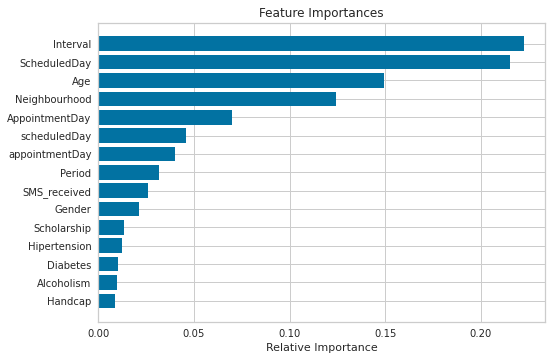

In [28]:
features = X.columns 
importances = modelOpt.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
#Applying LogisticRegression Model 


LogisticRegressionModel = LogisticRegression(penalty = 'l2', solver = 'sag', C = 1.0, random_state = 44)

LogisticRegressionModel.fit(X_train, y_train)


#Calculating Prediction
y_pred = LogisticRegressionModel.predict(X_test)

print('\n Logistic Regresiion Model Metrics: \n')


#Calculating Confusion Matrix
Confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', Confusion_matrix)
print('')

#Calculating Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
Accuracy_score = accuracy_score(y_test, y_pred)
print('Accuracy Score is : ', Accuracy_score)
print('')

#Calculating Recall Score : (Sensitivity) (TP / float(TP + FN))  
Recall_score = recall_score(y_test, y_pred, average = 'micro')
print('Recall Score is : ', Recall_score)
print('')

#Calculating Precision Score : (Specificity) #(TP / float(TP + FP))  
Precision_score = precision_score(y_test, y_pred, average = 'micro') 
print('Precision Score is : ', Precision_score)
print('')


Accuracy_results.append({'Logistic Regression Model': np.round(Accuracy_score, 3)})

## LOG Regression 

In [24]:
#Applying LogisticRegression Model
#adapted from https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_lr = GridSearchCV(lr, param_grid = grid_values,scoring = 'recall') #want to focus on recall becuase 
grid_lr.fit(X_train, y_train)



#Predict values based on new parameters
y_pred_lr = grid_lr.predict(X_test)
print('\n Logistic Regresiion Model Metrics: \n')





Accuracy_results.append({'Logistic Regression Model': np.round(Accuracy_score, 3)})

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-


 Logistic Regresiion Model Metrics: 



NameError: name 'Accuracy_results' is not defined

In [25]:
#Calculating Confusion Matrix
Confusion_matrix = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix is : \n', Confusion_matrix)
print('')

#Calculating Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
Accuracy_score = accuracy_score(y_test, y_pred_lr)
print('Accuracy Score is : ', Accuracy_score)
print('')

#Calculating Recall Score : (Sensitivity) (TP / float(TP + FN))  
Recall_score = recall_score(y_test, y_pred_lr)
print('Recall Score is : ', Recall_score)
print('')

#Calculating Precision Score : (Specificity) #(TP / float(TP + FP))  
Precision_score = precision_score(y_test, y_pred_lr) 
print('Precision Score is : ', Precision_score)
print('')

F1_score = f1_score(y_test, y_pred_lr)
print('F1 Score is : ', F1_score)

Confusion Matrix is : 
 [[28490   211]
 [ 6905   153]]

Accuracy Score is :  0.8010011465645013

Recall Score is :  0.021677529045055256

Precision Score is :  0.42032967032967034

F1 Score is :  0.041228779304769606


## We have very imbalanced classes 80 (negative)/20 (positive) so we employ SMOTENC, but first we will undersample the majority class before the oversampling of the minority class 

In [17]:
#should i drop sheduledDay & appointmentDay?
X.head()

,,Gender,Neighbourhood,appointmentDay,scheduledDay,Period,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Interval
PatientId,AppointmentID,,,,,,,,,,,,,
2.987250e+13,5642903,0,39,0,0,0,62,0,1,0,0,0,0,0
5.589978e+14,5642503,1,39,0,0,0,56,0,0,0,0,0,0,0
4.262962e+12,5642549,0,45,0,0,0,62,0,0,0,0,0,0,0
8.679512e+11,5642828,0,54,0,0,0,8,0,0,0,0,0,0,0
8.841186e+12,5642494,0,39,0,0,0,56,0,1,1,0,0,0,0


In [ ]:
['Gender', 'Neighbourhood', 'No-show', 'appointmentDay', 'scheduledDay',
       'Period']

In [15]:
X.dtypes

Gender            int64
Neighbourhood     int64
appointmentDay    int64
scheduledDay      int64
Period            int64
Age               int64
Scholarship       int64
Hipertension      int64
Diabetes          int64
Alcoholism        int64
Handcap           int64
SMS_received      int64
Interval          int64
dtype: object

In [14]:
pip install imblearn

     |████████████████████████████████| 206 kB 6.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [16]:
#Import the SMOTE-NC
from imblearn.over_sampling import SMOTENC

In [19]:
smotenc = SMOTENC([0,1,3,4,6,7,8,9,10],random_state = 191)
X_oversample, y_oversample = smotenc.fit_resample(X_train, y_train)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [21]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.99      0.89     28701
           1       0.35      0.02      0.04      7058

    accuracy                           0.80     35759
   macro avg       0.58      0.51      0.46     35759
weighted avg       0.72      0.80      0.72     35759



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [22]:
classifier = LogisticRegression()
classifier.fit(X_oversample, y_oversample)
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.73      0.79     28701
           1       0.32      0.52      0.39      7058

    accuracy                           0.69     35759
   macro avg       0.59      0.62      0.59     35759
weighted avg       0.75      0.69      0.71     35759



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression()

grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_lr = GridSearchCV(lr, param_grid = grid_values,scoring = 'recall') #want to focus on recall becuase 
grid_lr.fit(X_oversample, y_oversample)
print(classification_report(y_test, grid_lr.predict(X_test)))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 444, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-

              precision    recall  f1-score   support

           0       0.86      0.72      0.78     28701
           1       0.31      0.52      0.39      7058

    accuracy                           0.68     35759
   macro avg       0.59      0.62      0.59     35759
weighted avg       0.75      0.68      0.71     35759



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
y_oversample.value_counts()

1    57965
0    57965
Name: No-show, dtype: int64

In [28]:
from sklearn.ensemble import RandomForestClassifier

## Establish exhaustive gri search 
# https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

forest = RandomForestClassifier(random_state = 191)

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(forest, hyperF, cv = None, verbose = 2, 
                      n_jobs = -1) #None to use default 5-fold cross validation 
bestF = gridF.fit(X_oversample, y_oversample)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [29]:
print(classification_report(y_test, gridF.predict(X_test)))
#https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397

              precision    recall  f1-score   support

           0       0.85      0.80      0.83     28701
           1       0.35      0.44      0.39      7058

    accuracy                           0.73     35759
   macro avg       0.60      0.62      0.61     35759
weighted avg       0.75      0.73      0.74     35759



In [30]:
gridF.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [35]:
print('besr params', bestF.best_params_, bestF.best_score_)
print('best score', bestF.best_score_)

besr params {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200} 0.8170965237643404
best score 0.8170965237643404
